In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from math import sqrt

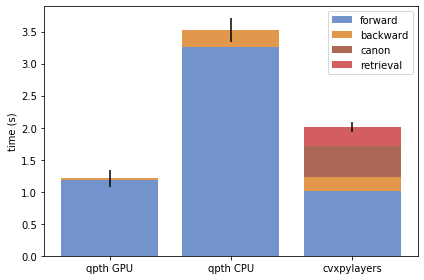

/home/shane/miniconda3/envs/cvxpylayers/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/shane/miniconda3/envs/cvxpylayers/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


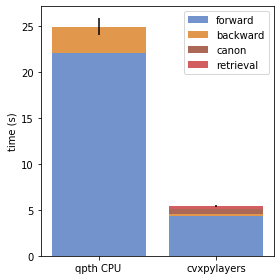

In [33]:
results = pd.read_csv('results.csv')

for qp in sorted(results.qp.unique()):
    for nz in results.nz.unique():
        for nbatch in results.nbatch.unique():
            x = 0
            xs, forwards, backwards, overall = [], [], [], []
            canons, dcanons = [], []
            for mode, cuda in [('qpth', 'True'), ('qpth', 'False'), ('cvxpylayers', 'False')]:
                for direction in ['forward', 'backward']:
                    a = results.query(
                        f"qp == '{qp}' & mode == '{mode}' & cuda == {cuda} & " + \
                        f"direction == '{direction}' & nz == {nz} & nbatch == {nbatch}"
                    )
                    t = np.array(a.time)
                    
                    if mode == 'cvxpylayers':
                        if direction == 'forward':
                            t -= np.array(a.canon_time)
                            canons.append(a.canon_time.mean())
                        else:
                            t -= np.array(a.dcanon_time)
                            dcanons.append(a.dcanon_time.mean())
                    if direction == 'forward':
                        forwards.append(np.mean(t))
                        if mode == 'cvxpylayers':
                            overall.append(t + np.array(a.canon_time))
                        else:
                            overall.append(t)
                    else:
                        backwards.append(np.mean(t))
                        if mode == 'cvxpylayers':
                            overall[-1] += t + np.array(a.dcanon_time)
                        else:
                            overall[-1] += t
                x += 1
                xs.append(x)
            
            if np.all(np.isnan(forwards)):
                continue
                
            xlabels = ['qpth GPU', 'qpth CPU', 'cvxpylayers']
            I = (~np.isnan(forwards))
            forwards = np.array(forwards)[I]
            backwards = np.array(backwards)[I]
            overall = np.array(overall)[I]
            xs = np.array(xs)[I]
            xlabels = np.array(xlabels)[I]
                
            fig, ax = plt.subplots(1, 1, figsize=(2*len(xs),4))
            ax.bar(xs, forwards, label='forward', color='#7293cb')
            ax.bar(xs[:-1], backwards[:-1], yerr=[o.std() for o in overall[:-1]], bottom = forwards[:-1], label='backward', color='#e1974c')
            ax.bar(xs[-1], backwards[-1], bottom=forwards[-1], color='#e1974c')
            ax.bar(xs[-1], canons[0], bottom=backwards[-1]+forwards[-1], color='#ab6857', label='canon')
            ax.bar(xs[-1], dcanons[0], yerr=overall[-1].std(), bottom=backwards[-1]+forwards[-1]+canons[-1], color='#d35e60', label='retrieval')
            ax.set_xticks(xs)
            ax.set_xticklabels(xlabels, rotation=0, ha='center')
            ax.set_ylabel('time (s)')
            ax.legend()
            fig.tight_layout()
            fig.savefig(f"{qp}_results.pdf")
            plt.show(fig)
            plt.close(fig)